In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

In [3]:
features = features.drop(['IsHoliday'], axis=1)

combined = sales.merge(features, on=['Store', 'Date'])
combined = combined.merge(stores, on=['Store'])

combined.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [5]:
combined = combined.fillna(value=0)
merged_df = combined

In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [7]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month

merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
merged_df['WeekOfYear'] = merged_df['WeekOfYear'].astype(np.int32)

merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

merged_df = merged_df.sort_values(by=['Store', 'Date'])
print(merged_df.head())

     Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0        1     1 2010-02-05      24924.50      False        42.31       2.572   
143      1     2 2010-02-05      50605.27      False        42.31       2.572   
286      1     3 2010-02-05      13740.12      False        42.31       2.572   
429      1     4 2010-02-05      39954.04      False        42.31       2.572   
572      1     5 2010-02-05      32229.38      False        42.31       2.572   

     MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0          0.0        0.0        0.0        0.0        0.0  211.096358   
143        0.0        0.0        0.0        0.0        0.0  211.096358   
286        0.0        0.0        0.0        0.0        0.0  211.096358   
429        0.0        0.0        0.0        0.0        0.0  211.096358   
572        0.0        0.0        0.0        0.0        0.0  211.096358   

     Unemployment Type    Size  Year  Month  WeekOfYear  DayOfWeek  

In [8]:
merged_df['Holiday_Weight'] = 1

super_bowl_week = (merged_df['Date'].dt.month == 2) & (merged_df['Date'].dt.isocalendar().week <= 6) & (merged_df['Date'].dt.dayofweek == 6)
labor_day_week = (merged_df['Date'].dt.month == 9) & (merged_df['Date'].dt.isocalendar().week == 36)
thanksgiving_week = (merged_df['Date'].dt.month == 11) & (merged_df['Date'].dt.isocalendar().week == 47)
christmas_period = (merged_df['Date'].dt.month == 12) & (merged_df['Date'].dt.isocalendar().week <= 24)

merged_df.loc[super_bowl_week, 'Holiday_Weight'] = 5
merged_df.loc[labor_day_week, 'Holiday_Weight'] = 5
merged_df.loc[thanksgiving_week, 'Holiday_Weight'] = 5
merged_df.loc[christmas_period, 'Holiday_Weight'] = 5

merged_df['Weighted_Weekly_Sales'] = merged_df['Weekly_Sales'] * merged_df['Holiday_Weight']

merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,CPI,Unemployment,Type,Size,Year,Month,WeekOfYear,DayOfWeek,Holiday_Weight,Weighted_Weekly_Sales
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,A,151315,2010,2,5,4,1,24924.50
143,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,A,151315,2010,2,5,4,1,50605.27
286,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,A,151315,2010,2,5,4,1,13740.12
429,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,A,151315,2010,2,5,4,1,39954.04
572,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,211.096358,8.106,A,151315,2010,2,5,4,1,32229.38


In [9]:
label_encoder = LabelEncoder()
merged_df['Type'] = label_encoder.fit_transform(merged_df['Type'])
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  421570 non-null  int64         
 1   Dept                   421570 non-null  int64         
 2   Date                   421570 non-null  datetime64[ns]
 3   Weekly_Sales           421570 non-null  float64       
 4   IsHoliday              421570 non-null  bool          
 5   Temperature            421570 non-null  float64       
 6   Fuel_Price             421570 non-null  float64       
 7   MarkDown1              421570 non-null  float64       
 8   MarkDown2              421570 non-null  float64       
 9   MarkDown3              421570 non-null  float64       
 10  MarkDown4              421570 non-null  float64       
 11  MarkDown5              421570 non-null  float64       
 12  CPI                    421570 non-null  float64  

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  421570 non-null  int64         
 1   Dept                   421570 non-null  int64         
 2   Date                   421570 non-null  datetime64[ns]
 3   Weekly_Sales           421570 non-null  float64       
 4   IsHoliday              421570 non-null  bool          
 5   Temperature            421570 non-null  float64       
 6   Fuel_Price             421570 non-null  float64       
 7   MarkDown1              421570 non-null  float64       
 8   MarkDown2              421570 non-null  float64       
 9   MarkDown3              421570 non-null  float64       
 10  MarkDown4              421570 non-null  float64       
 11  MarkDown5              421570 non-null  float64       
 12  CPI                    421570 non-null  float64  

Mean Squared Error: 199996743.723025
R-squared: 0.6195792334854084


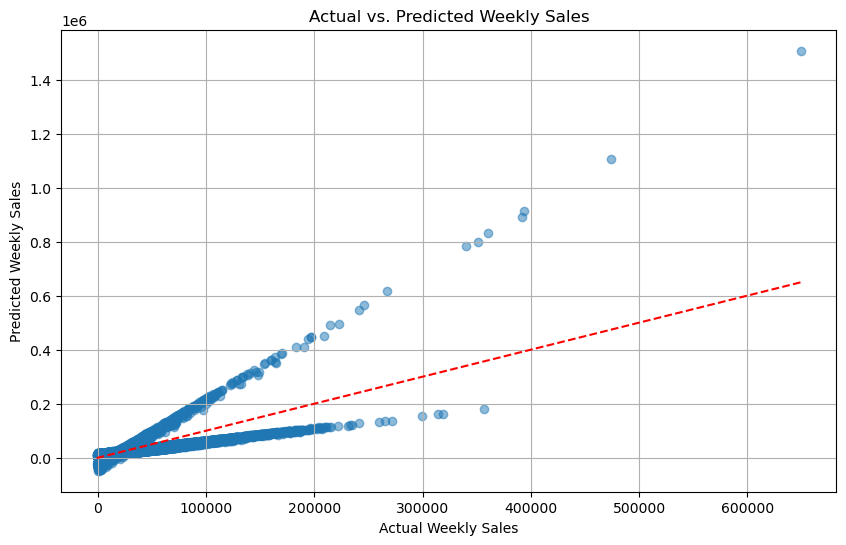

[-4.24583529e+01  5.00313946e+01  1.83395148e+01  9.56225221e+00
  2.36969111e+02 -2.16618207e-03  1.17891335e-02 -1.99824512e-01
  2.99319472e-02  6.12094540e-02 -7.96255060e+00 -1.08444613e+02
  8.37481452e+02  4.61405999e-02 -3.45719856e+02  5.55170059e+01
 -7.84350903e+03  4.74434789e-01]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np


X = merged_df.drop(columns=['WeekOfYear','Date', 'Weekly_Sales', 'DayOfWeek'])
y = merged_df['Weekly_Sales']

label_encoder = LabelEncoder()
X['Type'] = label_encoder.fit_transform(X['Type'])
X['IsHoliday'] = label_encoder.fit_transform(X['IsHoliday'])

linear_regression_model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_regression_model.fit(x_train, y_train)
y_pred = linear_regression_model.predict(x_test)

mse =mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()


print(linear_regression_model.coef_)

Mean Squared Error: 103435987.16348693
R-squared: 0.8032508090410624


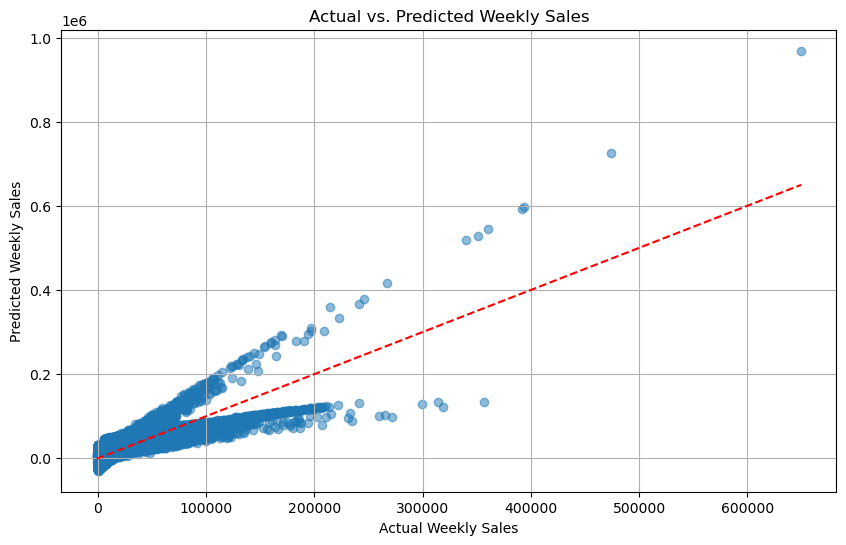

Feature Coefficients:
IsHoliday: -419.23520671977906
Temperature: -18.405556970534043
Fuel_Price: 218.88319172815957
MarkDown1: 0.010338206559739938
MarkDown2: -0.014660681111012153
MarkDown3: -0.09997772673363414
MarkDown4: 0.007071549086525408
MarkDown5: 0.034924359303545316
CPI: 53.15729354337941
Unemployment: -326.73811625333104
Type: -21218466924.95491
Size: -232428.5176677109
Year: -573.7156510099408
Month: 110.7836326227108
Holiday_Weight: -4687.744867463568
Weighted_Weekly_Sales: 0.29643106661933416
Store_2: 11851998345.928802
Store_3: -5260498054.63553
Store_4: 12678519494.76536
Store_5: -5845521718.927684
Store_6: 11898015616.15386
Store_7: 2484255294.909691
Store_8: 874621864.425833
Store_9: 15295713517.69554
Store_10: 15453550519.855639
Store_11: 13058761816.251091
Store_12: 12135859244.94076
Store_13: 15876502899.702267
Store_14: 11524509462.636166
Store_15: 14808548698.987003
Store_16: -657249598.5302969
Store_17: 7708092398.367029
Store_18: 14091743922.57294
Store_19: 12

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Separate features (X) and target variable (y)
X = merged_df.drop(columns=['WeekOfYear', 'Date', 'Weekly_Sales', 'DayOfWeek'])
y = merged_df['Weekly_Sales']

# One-hot encoding for 'Store' and 'Department'
X = pd.get_dummies(X, columns=['Store', 'Dept'], drop_first=True)

# Initialize the Linear Regression model
linear_regression_model = LinearRegression()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
linear_regression_model.fit(x_train, y_train)

# Predict on the test data
y_pred = linear_regression_model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()

# Display the model coefficients
print("Feature Coefficients:")
for feature, coef in zip(X.columns, linear_regression_model.coef_):
    print(f"{feature}: {coef}")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate 2013 dates and all combinations of stores and departments
stores = merged_df['Store'].unique()
departments = merged_df['Dept'].unique()
dates_2013 = pd.date_range(start='2013-01-01', end='2013-12-31', freq='D')

# Create a DataFrame with all combinations of Store, Department, and Date
data_2013 = pd.DataFrame([(store, dept, date) for store in stores for dept in departments for date in dates_2013],
                         columns=['Store', 'Dept', 'Date'])

# Step 2: Add additional features
# Add placeholders for features like IsHoliday, Temperature, etc.
# Replace these placeholders with actual data if available
data_2013['IsHoliday'] = False  # Default to non-holiday
data_2013['Temperature'] = merged_df['Temperature'].mean()  # Use average temperature
data_2013['Fuel_Price'] = merged_df['Fuel_Price'].mean()    # Use average fuel price
data_2013['MarkDown1'] = 0
data_2013['MarkDown2'] = 0
data_2013['MarkDown3'] = 0
data_2013['MarkDown4'] = 0
data_2013['MarkDown5'] = 0
data_2013['CPI'] = merged_df['CPI'].mean()
data_2013['Unemployment'] = merged_df['Unemployment'].mean()
data_2013['Type'] = merged_df['Type'].mode()[0]  # Use the most common store type
data_2013['Size'] = merged_df['Size'].mean()
data_2013['Year'] = 2013
data_2013['Month'] = data_2013['Date'].dt.month
data_2013['WeekOfYear'] = data_2013['Date'].dt.isocalendar().week
data_2013['DayOfWeek'] = data_2013['Date'].dt.dayofweek
data_2013['Holiday_Weight'] = 1 # Default to 0, update if holiday data is available

# Step 3: Prepare the DataFrame for Prediction
# Retain original columns for output
original_data = data_2013[['Store', 'Dept', 'Date']].copy()

# One-hot encode Store and Dept, and align columns with training set
data_2013 = pd.get_dummies(data_2013, columns=['Store', 'Dept'], drop_first=True)
data_2013 = data_2013.reindex(columns=x_train.columns, fill_value=0)

# Step 4: Predict Weekly Sales for 2013
original_data['Predicted_Weekly_Sales'] = linear_regression_model.predict(data_2013)

# Step 5: Save the Results
output_csv_path = 'predicted_2013_weekly_sales.csv'
original_data.to_csv(output_csv_path, index=False)

print(f"Predictions for 2013 saved to {output_csv_path}")


Predictions for 2013 saved to predicted_2013_weekly_sales.csv


In [ ]:
#Placeholder cell for code I am testing

import numpy as np
import pandas as pd

#date_range_2013 = pd.date_range(start="2013-01-01", end="2013-12-31", freq='W-FRI')

#synthetic_2013 = []
#for store in merged_df['Store'].unique():
 #  for week in range(1, 53):
      #  store_data = merged_df[merged_df['Store'] == store]
      #  if not store_data.empty:
        #    avg_values = store_data.mean(numeric_only=True)
        #    std_values = store_data.std(numeric_only=True)
            
         #   synthetic_2013.append({
              #  'Store': store,
             #   'Date': date_range_2013[week - 1],
             #   'IsHoliday': False,  # Default to False, adjust for specific dates as needed
            #    'Temperature': np.random.normal(avg_values['Temperature'], std_values['Temperature']),
                #'Fuel_Price': np.random.normal(avg_values['Fuel_Price'], std_values['Fuel_Price']),
                #'MarkDown1': np.random.normal(avg_values['MarkDown1'], std_values['MarkDown1']),
                #'MarkDown2': np.random.normal(avg_values['MarkDown2'], std_values['MarkDown2']),
               # 'MarkDown3': np.random.normal(avg_values['MarkDown3'], std_values['MarkDown3']),
               # 'MarkDown4': np.random.normal(avg_values['MarkDown4'], std_values['MarkDown4']),
               # 'MarkDown5': np.random.normal(avg_values['MarkDown5'], std_values['MarkDown5']),
               # 'CPI': np.random.normal(avg_values['CPI'], std_values['CPI']),
               # 'Unemployment': np.random.normal(avg_values['Unemployment'], std_values['Unemployment']),
               # 'Type': store_data['Type'].mode()[0],
               # 'Size': avg_values['Size'],
               # 'Weekly_Sales': None,  # Placeholder for predictions
               # 'Year': 2013,
               # 'Month': date_range_2013[week - 1].month,
               # 'WeekOfYear': week,
               # 'DayOfWeek': date_range_2013[week - 1].weekday(),
               # 'Holiday_Weight': 1,  # Default value, can be adjusted for holidays
               # 'Weighted_Weekly_Sales': None  # Placeholder for predictions
            })






synthetic_2013_df = pd.DataFrame(synthetic_2013)
synthetic_2013_df.fillna(0)

super_bowl_week = (
    (synthetic_2013_df['Date'].dt.month == 2) & 
    (synthetic_2013_df['Date'].dt.isocalendar().week <= 6) & 
    (synthetic_2013_df['Date'].dt.dayofweek == 6)
)
labor_day_week = (
    (synthetic_2013_df['Date'].dt.month == 9) & 
    (synthetic_2013_df['Date'].dt.isocalendar().week == 36)
)
thanksgiving_week = (
    (synthetic_2013_df['Date'].dt.month == 11) & 
    (synthetic_2013_df['Date'].dt.isocalendar().week == 47)
)
christmas_period = (
    (synthetic_2013_df['Date'].dt.month == 12) & 
    (synthetic_2013_df['Date'].dt.isocalendar().week <= 24)
)

# Apply weights to the synthetic data
#synthetic_2013_df.loc[super_bowl_week, 'Holiday_Weight'] = 5
#synthetic_2013_df.loc[labor_day_week, 'Holiday_Weight'] = 5
#synthetic_2013_df.loc[thanksgiving_week, 'Holiday_Weight'] = 5
#synthetic_2013_df.loc[christmas_period, 'Holiday_Weight'] = 5




In [ ]:
#synthetic_2013_df['Type'] = label_encoder.transform(synthetic_2013_df['Type'])

#X_2013 = synthetic_2013_df.drop(columns=['Weekly_Sales','WeekOfYear', 'Date', 'Weighted_Weekly_Sales'])

#predictions_2013 = linear_regression_model.predict(X_2013)

#synthetic_2013_df['Weighted_Weekly_Sales'] = predictions_2013
#print(synthetic_2013_df.head(50))